In [1]:
import sys
sys.path.append('..')
from pathlib import Path
from datetime import datetime
from dateutil import tz

import matplotlib.patches as mpatches
import geopandas
import pandas as pd
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES

from Map import Map

In [2]:
SPC_DAY = 1
LOCATION = 'southeast'
GRAPHICS_DIR = Path('.') / '..' / '..' / 'graphics' / 'spc'

In [3]:
def get_gdf(day):
    cat_gdf = geopandas.read_file(f'https://www.spc.noaa.gov/products/fire_wx/day{SPC_DAY}firewx-shp.zip')
    cat_gdf = cat_gdf.to_crs(epsg=4326)
    cat_gdf.crs
    return cat_gdf
    
cat_gdf = get_gdf(SPC_DAY)
cat_gdf

,DN,VALID,EXPIRE,ISSUE,LABEL,LABEL2,stroke,fill,geometry
0,0,202304291700,202304301200,202304291640,NaN,NaN,NaN,NaN,None


In [4]:
# Get time data
start_time = cat_gdf['VALID'][0]
end_time = cat_gdf['EXPIRE'][0]

from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/New_York')

def convert_datetime_from_spc_to_local(string):
    utc_time = datetime.strptime(string, '%Y%m%d%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

def get_valid_day(string):
    utc_time = datetime.strptime(string, '%Y%m%d%H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    valid_day = datetime.strftime(eastern, '%A').lstrip('0').replace(' 0', ' ')
    return valid_day

valid_day_start = get_valid_day(start_time)
valid_day_end = get_valid_day(end_time)

In [5]:
# Set colors

cat_plot_colors = {
    '0': 'orange',
    '5': 'brown',
    '8': 'red',
    '10': 'magenta'}

# Generate legend patches
legend_patches = []
for risk in cat_plot_colors.keys():
   patch = mpatches.Patch(color=cat_plot_colors[risk], label=risk)
   legend_patches.append(patch)

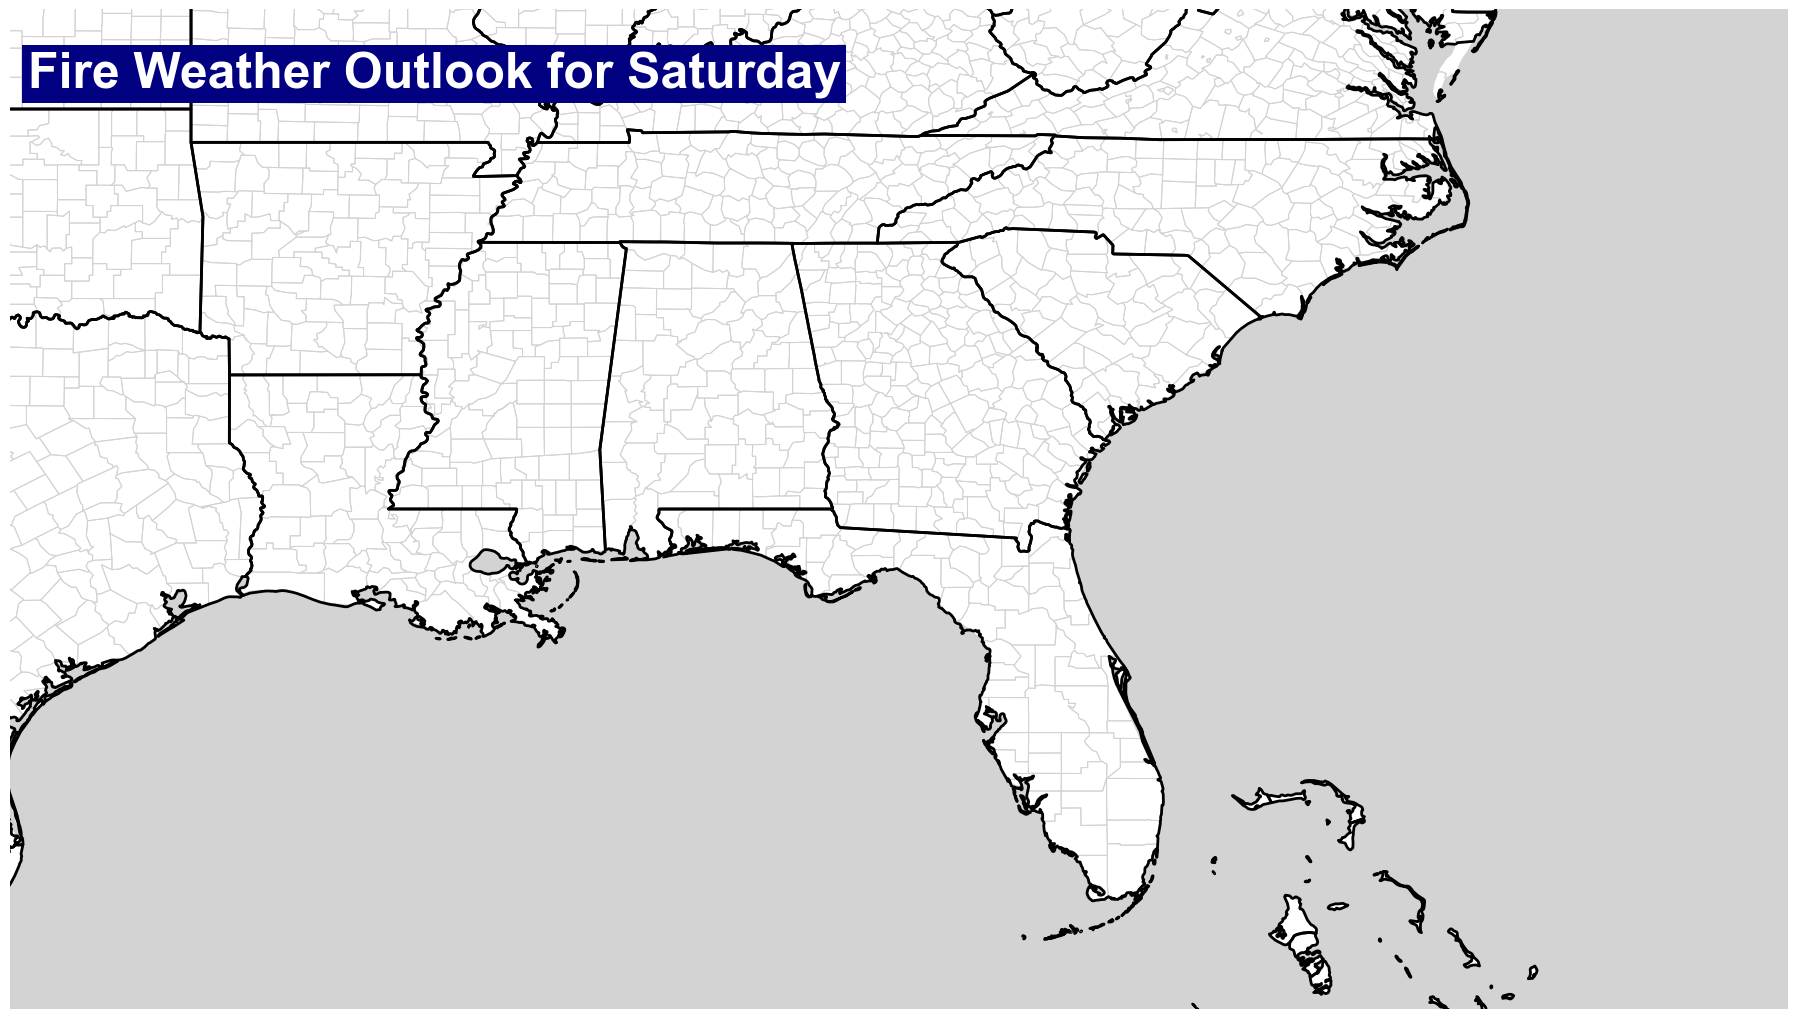

In [6]:
new_map = Map(LOCATION)
new_map.add_counties()
new_map.add_title(f'Fire Weather Outlook for {valid_day_start}')

fig, ax = new_map.make_map()

def any_risk_areas(geometries):
    '''Checks to see if there are any areas flagged for fire weather concerns'''
    return True if cat_gdf['geometry'].any() else False

def plot_risk_areas():
    for key in cat_plot_colors.keys():
        geometries = cat_gdf[cat_gdf['DN'] == int(key)]
        ax.add_geometries(geometries['geometry'], crs=ccrs.PlateCarree(),
                          facecolor=cat_plot_colors[key], edgecolor='black',
                          alpha=0.5,)
        
def plot_fire_outlook():
    if not any_risk_areas(cat_gdf['geometry']):
        return
    plot_risk_areas()
    ax.legend(handles=legend_patches, fontsize=32, loc='lower left',)
    fig.savefig(f'{GRAPHICS_DIR}/fire_day{SPC_DAY}_{LOCATION.lower()}.png', dpi=72)
    
plot_fire_outlook()